In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import scipy
from scipy.special import jv, hankel1
import matplotlib.pyplot as plt

# General parameters
weights = 1
iterations = 10000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 350
activation = "tanh"

# Problem parameters
k0 = 2
wave_len = 2 * np.pi / k0
length = 2 * np.pi
R =  np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)

# Computational domain
outer = dde.geometry.Rectangle([-length / 2, -length / 2], [length / 2, length / 2])
inner = dde.geometry.Disk([0, 0], R)

geom = outer - inner

# Exact solution
def sound_hard_circle_deepxde(k0, a, points):

    fem_xx = points[:, 0:1]
    fem_xy = points[:, 1:2]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    n_terms = int(30 + (k0 * a) ** 1.01)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n - 1, k0 * a) - n / (k0 * a) * jv(n, k0 * a)
        hankel_deriv = n / (k0 * a) * hankel1(n, k0 * a) - hankel1(n + 1, k0 * a)
        u_sc += (
            -((1j) ** (n))
            * (bessel_deriv / hankel_deriv)
            * hankel1(n, k0 * r)
            * np.exp(1j * n * theta)
        ).ravel()
    return u_sc


# Definition of the pde
def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    return [-y0_xx - y0_yy - k0**2 * y0, -y1_xx - y1_yy - k0**2 * y1]


def sol(x):
    result = sound_hard_circle_deepxde(k0, R, x).reshape((x.shape[0], 1))
    real = np.real(result)
    imag = np.imag(result)
    return np.hstack((real, imag))


# Boundary conditions
def boundary(x, on_boundary):
    return on_boundary


def boundary_outer(x, on_boundary):
    return on_boundary and outer.on_boundary(x)


def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)


def func0_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.real(-g)


def func1_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.imag(-g)


def func0_outer(x, y):
    result = -k0 * y[:, 1:2]
    return result


def func1_outer(x, y):
    result = k0 * y[:, 0:1]
    return result


# ABCs
bc0_inner = dde.NeumannBC(geom, func0_inner, boundary_inner, component=0)
bc1_inner = dde.NeumannBC(geom, func1_inner, boundary_inner, component=1)

bc0_outer = dde.RobinBC(geom, func0_outer, boundary_outer, component=0)
bc1_outer = dde.RobinBC(geom, func1_outer, boundary_outer, component=1)

bcs = [bc0_inner, bc1_inner, bc0_outer, bc1_outer]

loss_weights = [1, 1, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx**2,
    num_boundary=8 * nx,
    num_test=5 * nx**2,
    solution=sol,
)
net = dde.maps.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

model.compile(
    "adam", lr=learning_rate, loss_weights=loss_weights, metrics=["l2 relative error"]
)
losshistory, train_state = model.train(iterations=iterations)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/tmp/ipykernel_9871/562704619.py:46: RuntimeWarning: invalid value encountered in multiply
  -((1j) ** (n))


Compiling model...
'compile' took 0.762988 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [7.34e-03, 5.68e-03, 1.97e-02, 1.87e+00, 1.25e-02, 1.02e-03]    [9.10e-03, 7.06e-03, 1.97e-02, 1.87e+00, 1.25e-02, 1.02e-03]    [nan]         
1000      [2.17e-02, 4.26e-02, 1.94e-02, 1.13e-01, 1.44e-01, 3.54e-02]    [5.66e-01, 1.18e+00, 1.94e-02, 1.13e-01, 1.44e-01, 3.54e-02]    [nan]         
2000      [3.48e-03, 3.75e-03, 1.25e-02, 2.06e-02, 8.91e-03, 2.72e-03]    [5.56e+01, 5.98e+01, 1.25e-02, 2.06e-02, 8.91e-03, 2.72e-03]    [nan]         
3000      [8.97e-03, 7.04e-03, 1.15e-02, 2.05e-02, 3.93e-03, 2.74e-03]    [6.85e+01, 6.88e+01, 1.15e-02, 2.05e-02, 3.93e-03, 2.74e-03]    [nan]         
4000      [5.73e-03, 1.17e-02, 1.00e-02, 1.93e-02, 1.98e-03, 1.39e-03]    [7.21e+01, 7.14e+01, 1.00e-02, 1.93e-02, 1.98e-03, 1.39e-03]    [nan]         


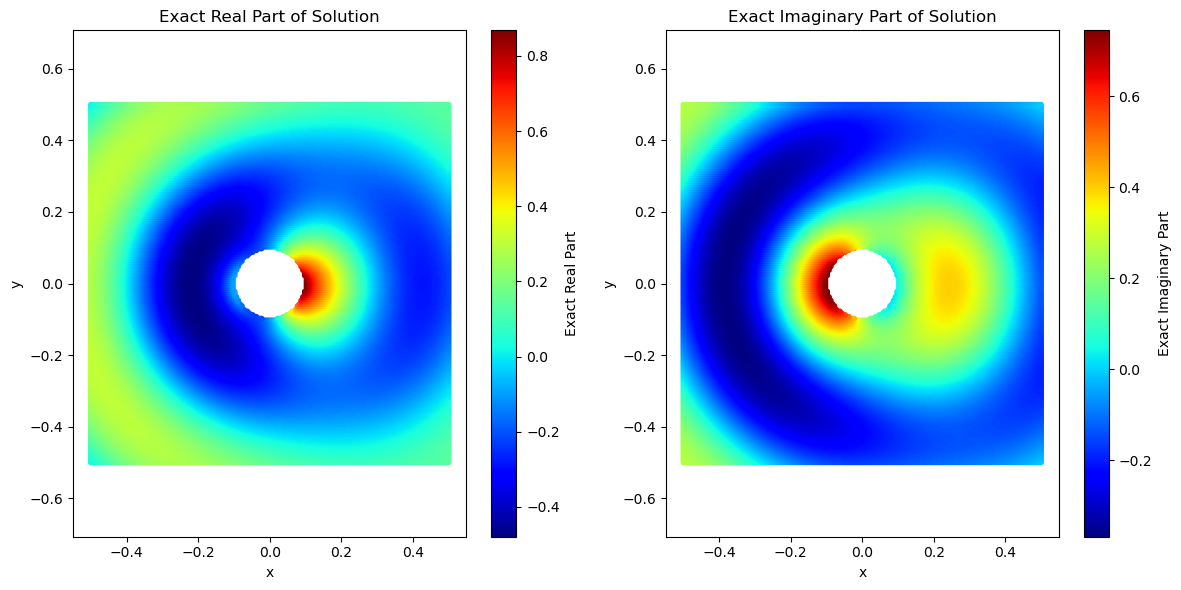

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, hankel1

# Function to compute the exact solution
def sound_hard_circle_exact(k0, a, points):
    fem_xx = points[:, 0:1]
    fem_xy = points[:, 1:2]
    r = np.sqrt(fem_xx**2 + fem_xy**2)
    theta = np.arctan2(fem_xy, fem_xx)
    n_terms = int(30 + (k0 * a) ** 1.01)

    u_sc = np.zeros((points.shape[0]), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n - 1, k0 * a) - n / (k0 * a) * jv(n, k0 * a)
        hankel_deriv = n / (k0 * a) * hankel1(n, k0 * a) - hankel1(n + 1, k0 * a)
        u_sc += (
            -((1j) ** n) * (bessel_deriv / hankel_deriv) * hankel1(n, k0 * r) * np.exp(1j * n * theta)
        ).ravel()
    return u_sc

# Parameters
k0 = 10  # Wave number
R = 0.1#np.pi / 4  # Radius of the circle
length = 1#2 * np.pi  # Length of the domain
grid_size = 200  # Resolution of the grid

# Create a uniform grid over the specified domain
x = np.linspace(-length / 2, length / 2, grid_size)
y = np.linspace(-length / 2, length / 2, grid_size)
x_grid, y_grid = np.meshgrid(x, y)

# Flatten the grid for processing
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

# Filter out points inside the circle
radii = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
mask = radii > R
filtered_points = points[mask]

# Calculate the exact solution at the remaining points
exact_solution = sound_hard_circle_exact(k0, R, filtered_points)

# Extract real and imaginary parts of the exact solution
real_exact = np.real(exact_solution)
imag_exact = np.imag(exact_solution)

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Scatter Plot for Exact Real Part
plt.subplot(1, 2, 1)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=-real_exact, cmap='jet', s=10)
plt.colorbar(label='Exact Real Part')
plt.title('Exact Real Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Scatter Plot for Exact Imaginary Part
plt.subplot(1, 2, 2)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=-imag_exact, cmap='jet', s=10)
plt.colorbar(label='Exact Imaginary Part')
plt.title('Exact Imaginary Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.show()


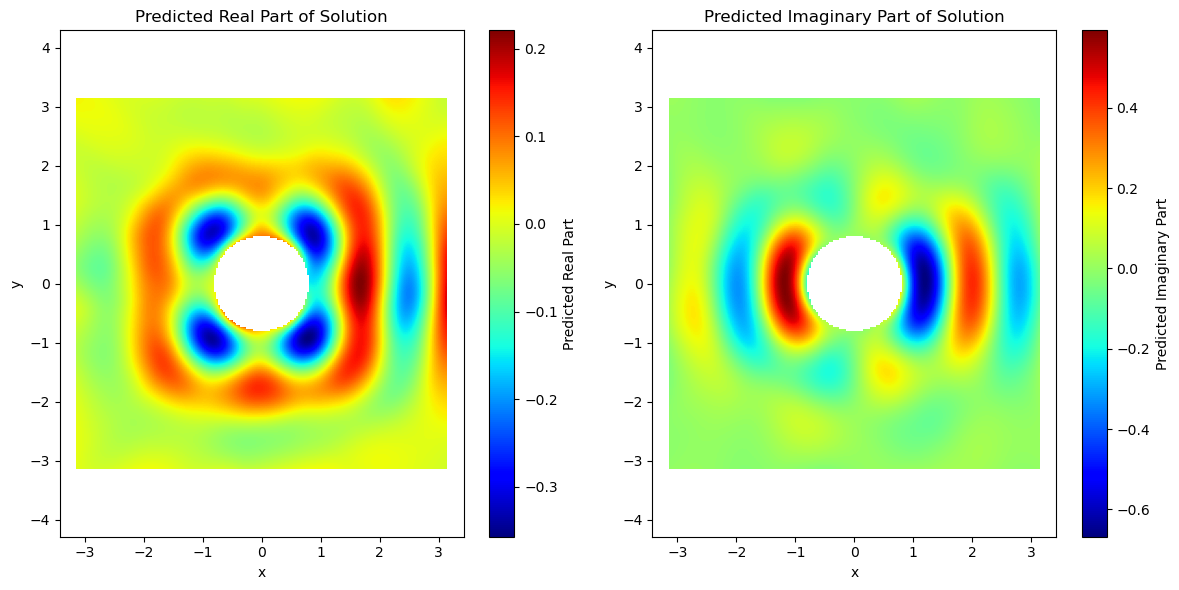

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

# Parameters
R = np.pi / 4  # Radius of the circle
length = 2 * np.pi  # Length of the domain
grid_size = 200  # Define grid resolution

# Generate a uniform grid
x1 = np.linspace(-length / 2, length / 2, grid_size)
x2 = np.linspace(-length / 2, length / 2, grid_size)
x_grid, y_grid = np.meshgrid(x1, x2)
x_test = np.vstack((x_grid.ravel(), y_grid.ravel())).T

# Filter out points inside the circle
radii = np.sqrt(x_test[:, 0]**2 + x_test[:, 1]**2)
mask = radii > R
filtered_x_test = x_test[mask]

# Get the predicted solution on the filtered grid
y_pred = model.predict(filtered_x_test)

# Create grids for imshow
y_pred_real = np.full((grid_size, grid_size), np.nan)
y_pred_imag = np.full((grid_size, grid_size), np.nan)

# Fill the grids with predicted values where applicable
for i, (x, y) in enumerate(filtered_x_test):
    x_idx = np.argmin(np.abs(x1 - x))
    y_idx = np.argmin(np.abs(x2 - y))
    y_pred_real[y_idx, x_idx] = y_pred[i, 0]
    y_pred_imag[y_idx, x_idx] = y_pred[i, 1]

# Plot the predicted solution using imshow
plt.figure(figsize=(12, 6))

# Plot Predicted Real Part
plt.subplot(1, 2, 1)
plt.imshow(-y_pred_real, extent=(-length/2, length/2, -length/2, length/2), origin='lower', cmap='jet')
plt.colorbar(label='Predicted Real Part')
plt.title('Predicted Real Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Plot Predicted Imaginary Part
plt.subplot(1, 2, 2)
plt.imshow(-y_pred_imag, extent=(-length/2, length/2, -length/2, length/2), origin='lower', cmap='jet')
plt.colorbar(label='Predicted Imaginary Part')
plt.title('Predicted Imaginary Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.show()
